# **AAI 511 - Final Project (G1)**

In [1]:
pip install pretty-midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 44.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.9 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=2f9198cd1510841ef3642ab32be5617ecabb29c53631448e1325f38865d6691d
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty-midi


In [2]:
pip install mido

In [4]:
# Load libraries
import os
import shutil
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mido
import pretty_midi
import kagglehub
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

In [5]:
# Set device
gpu_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
# Download the dataset off Kaggle
path = kagglehub.dataset_download("blanderbuss/midi-classic-music")
zip_path = os.path.join(path, 'midiclassics.zip')
extract_path = os.path.join('data', 'kaggle', 'midiclassics')

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extracted files to:", extract_path)

Extracted files to: data/kaggle/midiclassics


In [97]:
# Clean dataset
# Use a portion of Antonio's code as a baseline to set ourselves up the same
# Target composers
TARGET_COMPOSERS = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# Keep directories that contain a target composer's name
for item in os.listdir(extract_path):
    item_path = os.path.join(extract_path, item)
    if not any(composer.lower() in item.lower() for composer in TARGET_COMPOSERS):
        if os.path.isfile(item_path):
            os.remove(item_path)
            print(f"Deleted file: {item_path}")
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
            print(f"Deleted directory: {item_path}")

# also delete "C.P.E.Bach" files. This was the son of J.S. Bach, and we want to keep only the main composers
for item in os.listdir(extract_path):
    if 'C.P.E.Bach' in item:
        item_path = os.path.join(extract_path, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
            print(f"Deleted file: {item_path}")
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
            print(f"Deleted directory: {item_path}")

Deleted file: data/kaggle/midiclassics/Liszt Paganini Etude n2.mid
Deleted file: data/kaggle/midiclassics/Bizet Symphony in C 4mov.mid
Deleted file: data/kaggle/midiclassics/Debussy Suite Bergamasque 1mov.mid
Deleted file: data/kaggle/midiclassics/Pollen Beguine Royale.mid
Deleted file: data/kaggle/midiclassics/Tchaikovsky Lake Of The Swans Act 2 13mov.mid
Deleted file: data/kaggle/midiclassics/Kuhlau Sonatina op55 n1.mid
Deleted directory: data/kaggle/midiclassics/Arndt
Deleted directory: data/kaggle/midiclassics/Grainger
Deleted file: data/kaggle/midiclassics/Rimsky Korsakov ''Flight Of the Bumblebee''.mid
Deleted directory: data/kaggle/midiclassics/Mendelssohn
Deleted file: data/kaggle/midiclassics/Buxethude Buxwv157 Tocatta and Fugue.mid
Deleted file: data/kaggle/midiclassics/Buxethude Buxwv155 Toccata.mid
Deleted directory: data/kaggle/midiclassics/Sudds
Deleted directory: data/kaggle/midiclassics/Lyssenko
Deleted file: data/kaggle/midiclassics/Buxethude Buxwv138 Prelude.mid
Delet

# Mido Feature Extraction - Notes, Velocity, Time

The function below reads a MIDI files and extracts features such as pitch, timing, and velocity into a fixed length feature vector.

In [98]:
def extract_features(midi_path, max_e=1000):
    try:
        # Load MIDI file
        midi_file = mido.MidiFile(midi_path)
        notes = []
        # Loop through MIDI files
        for e in midi_file:
            # Only the note being played
            if e.type == 'note_on' and e.velocity > 0:
                # Pitch (note), time, velocity
                notes.append((e.note, e.velocity, e.time))
            # Stop collecting after max events
            if len(notes) >= max_e:
                break
        if not notes:
            return None
        # Convert list to numpy array
        matrix_n = np.array(notes)
        # Pad with zeros if its less than the max. If more, cut
        if matrix_n.shape[0] < max_e:
            padding = max_e - matrix_n.shape[0]
            matrix_n = np.pad(matrix_n, ((0, padding), (0, 0)), mode='constant')
        else:
            matrix_n = matrix_n[:max_e]
        # Flatten - 1D feature vector
        return matrix_n.flatten()
    except Exception as error:
        print(f"Skip {midi_path}: {error}")
        return None

# PrettyMIDI Feature Extraction - Chords & Tempo

The function below uses Pretty MIDI to extract two features from a MIDI file: Average Tempo (BPM), and Chrodal Pitch Class Profile (Chroma). These features are useful for modeling the harmonic and rhythmic aspects of music.

In [99]:
def extract_chords_tempo(midi_path):
    try:
        # Load MIDI file using PrettyMIDI
        midi_obj = pretty_midi.PrettyMIDI(midi_path)

        # Extract tempo changes & calculate avg tempo (BPM)
        tempo = midi_obj.get_tempo_changes()[1]
        avg_tempo = np.mean(tempo) if len(tempo) > 0 else 0.0

        # Extract chroma feature, and the avg across all time frames
        chroma = midi_obj.get_chroma()
        chord = np.mean(chroma, axis=1)

        return chord, avg_tempo
    except Exception as error:
        print(f"Tempo and/or Chord extraction has failed {midi_path}: {error}")
        return None, None

  The section below processes all MIDI files for a set of target composers and extracts three types of musical features: Note Features, Chord Features, and Tempo Features.

In [105]:
# Initialize empty lists to store each feature
note_f = [] # From Mido: pitch, velocity, time
chord_f = [] # From PrettyMIDI: avg chroma
tempo_f = [] # From PrettyMIDI: avg BPM
composer_label = [] # Composer names

# Loop through each composer
for name in TARGET_COMPOSERS:
    composers = os.path.join(extract_path, name)

    # Loop through each file
    for feat_name in os.listdir(composers):
        if feat_name.endswith(".mid") or feat_name.endswith(".midi"):
            f_path = os.path.join(composers, feat_name)

            # Extract note features using mido
            feat_note = extract_features(f_path)
            # Extract tempo and chrod features using prettymidi
            feat_chord, feat_tempo = extract_chords_tempo(f_path)

            # Append only if all  feature extractions were successful
            if feat_note is not None and feat_chord is not None and feat_tempo is not None:
                note_f.append(feat_note)
                chord_f.append(feat_chord)
                tempo_f.append([feat_tempo])
                composer_label.append(name)

# Single feature matrix - stack notes, chord, and tempo features
X_full = np.hstack([
    np.array(note_f),
    np.array(chord_f),
    np.array(tempo_f)
])

# Convert the composer name to numerical labels using LabelEncoder
le = LabelEncoder()
y_full = le.fit_transform(composer_label)

# Convert feature matrix and labels into PyTorch tensors
X_ten = torch.tensor(X_full, dtype=torch.float32)
y_ten = torch.tensor(y_full, dtype=torch.long)

# Create PyTorch dataset and loader
dataset = TensorDataset(X_ten, y_ten)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"Total processed samples: {len(dataset)}")
print(f"Composer classes: {le.classes_}")

/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Skip data/kaggle/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Tempo and/or Chord extraction has failed data/kaggle/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Total processed samples: 480
Composer classes: ['Bach' 'Beethoven' 'Chopin' 'Mozart']


# Tempo Distribution

This plot visualizes the distribution of average tempos (BPM) for each composer's MIDI pieces.

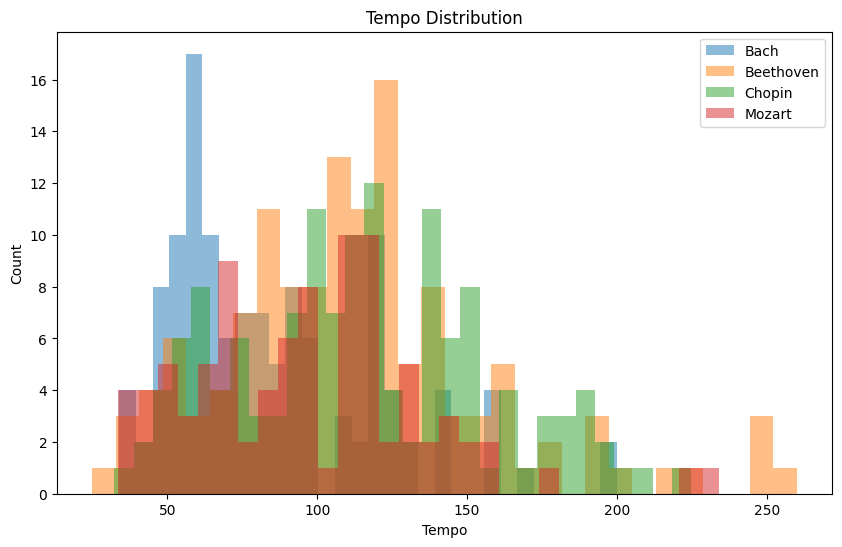

In [19]:
# Convert tempo features and labels to numpy array
tempos = np.array(tempo_f).flatten()
labels = np.array(composer_label)

plt.figure(figsize=(10,6))

# Plot a histogram of tempos for each of the composers
for composer in np.unique(labels):
    composer_tempo = tempos[labels == composer]
    plt.hist(composer_tempo, bins=30, alpha=0.5, label=composer)

plt.title("Tempo Distribution")
plt.xlabel("Tempo")
plt.ylabel("Count")
plt.legend()
plt.show()

# Pitch Distribution

This plot shows how the average pitch varies across different composers' pieces.

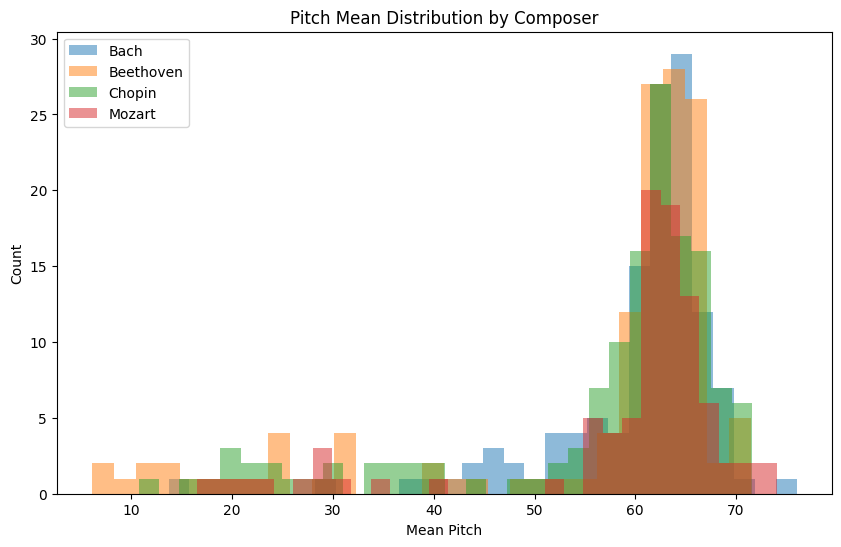

In [21]:
# Reshape note_features to have shape (num_samples, max_events, 3)
note_features_reshaped = np.array(note_f).reshape(len(note_f), -1, 3)

# Calculate mean pitch, velocity, and time across events for each sample
pitch_mean = np.mean(note_features_reshaped[:, :, 0], axis=1)
velocity_mean = np.mean(note_features_reshaped[:, :, 1], axis=1) # Not used in this plot
time_mean = np.mean(note_features_reshaped[:, :, 2], axis=1) # Not used in this plot

# Use the mean pitch as the values to plot
pitch_vals = pitch_mean

# Convert list of composer labels into a numpy array
lab = np.array(composer_label)

# Plot histogram
plt.figure(figsize=(10, 6))
for composer in np.unique(lab):
    comp_pitch = pitch_vals[lab == composer]
    plt.hist(comp_pitch, bins=30, alpha=0.5, label=composer)

plt.title("Pitch Mean Distribution by Composer")
plt.xlabel("Mean Pitch")
plt.ylabel("Count")
plt.legend()
plt.show()

# Velocity Distribution

Thisplot shows how the average velocity varies across different composers' pieces.

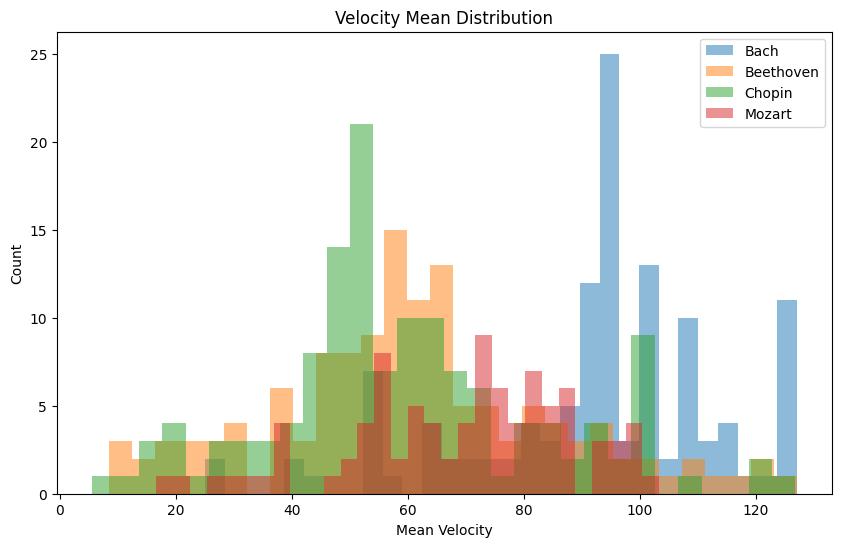

In [22]:
# Use velocity mean values that we computed prior
velocity_vals = velocity_mean

# Plot histogram of mean velcoities for each composer
plt.figure(figsize=(10, 6))
for composer in np.unique(labels):
    comp_velocity = velocity_vals[labels == composer]
    plt.hist(comp_velocity, bins=30, alpha=0.5, label=composer)

plt.title("Velocity Mean Distribution")
plt.xlabel("Mean Velocity")
plt.ylabel("Count")
plt.legend()
plt.show()

# Time Distribution

This plot shows how the average time interval between note events varies across composers.

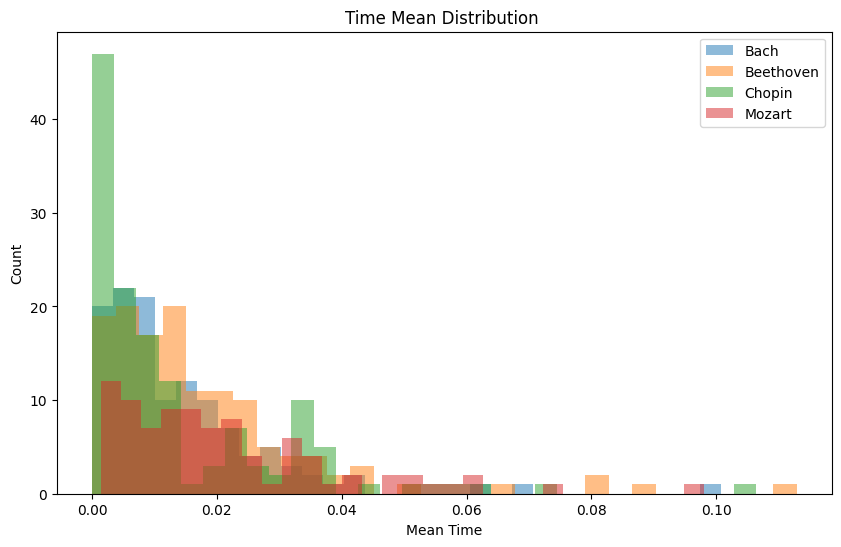

In [23]:
# Use mean time intervals - computed prior
time_vals = time_mean

# Plot histogram of mean time intervals for each composer
plt.figure(figsize=(10, 6))
for composer in np.unique(labels):
    comp_time = time_vals[labels == composer]
    plt.hist(comp_time, bins=30, alpha=0.5, label=composer)

plt.title("Time Mean Distribution ")
plt.xlabel("Mean Time")
plt.ylabel("Count")
plt.legend()
plt.show()

# Chord Distributions

The following histograms visualize the distribution of intensity values for each of the 12 pitch classes (chords) extracted from MIDI files.

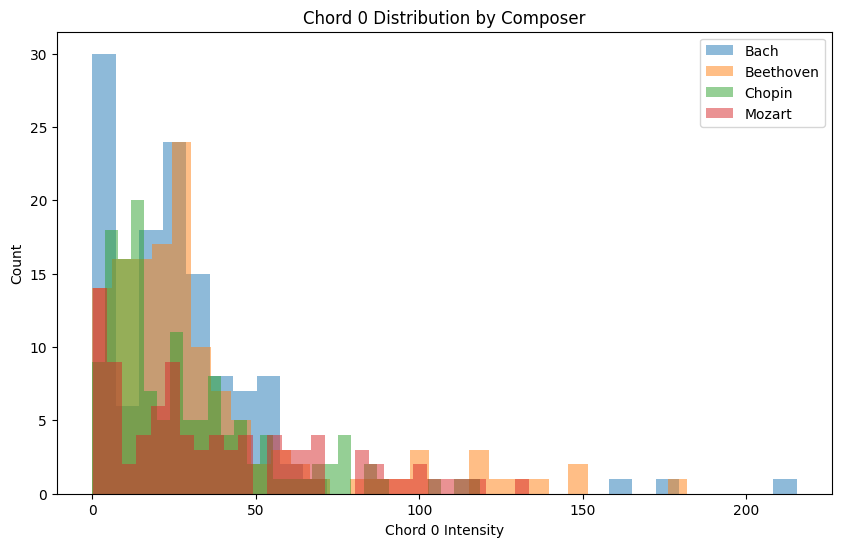

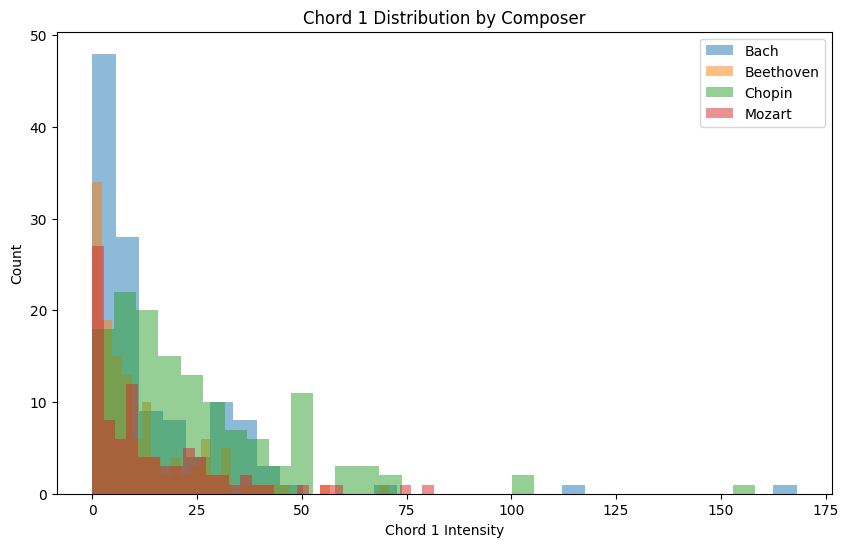

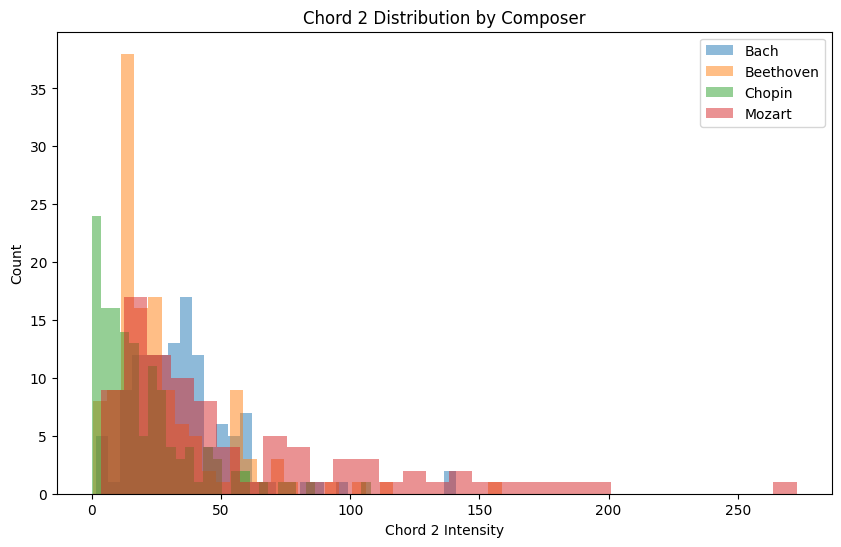

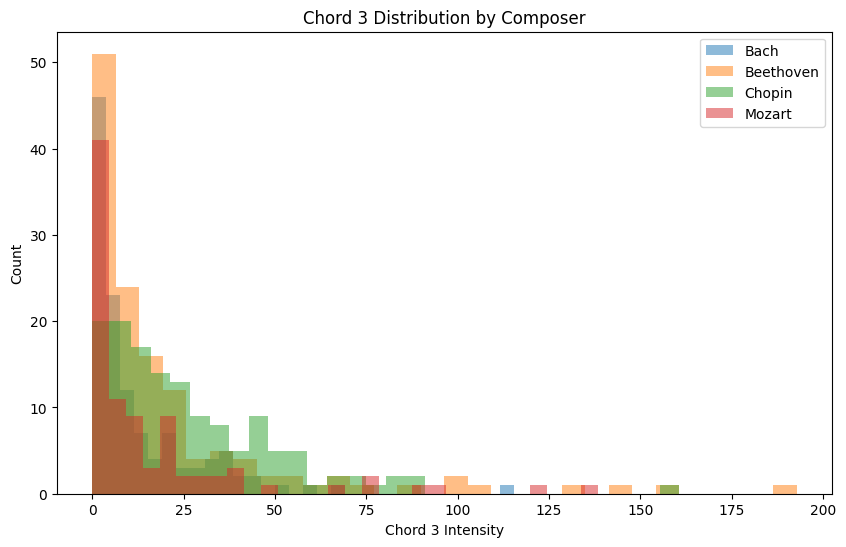

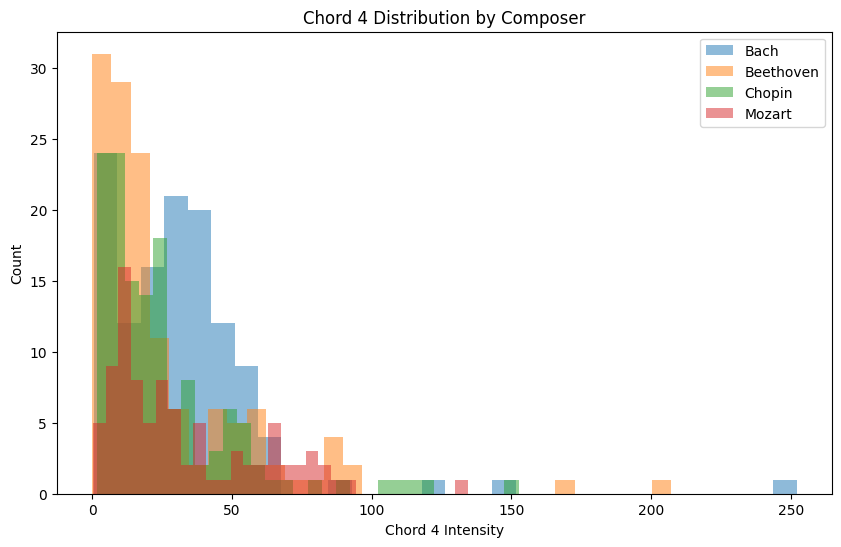

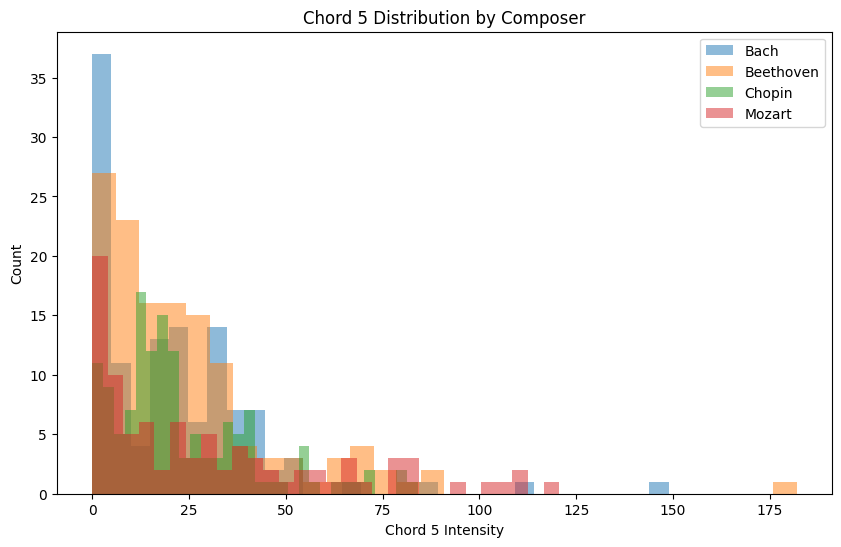

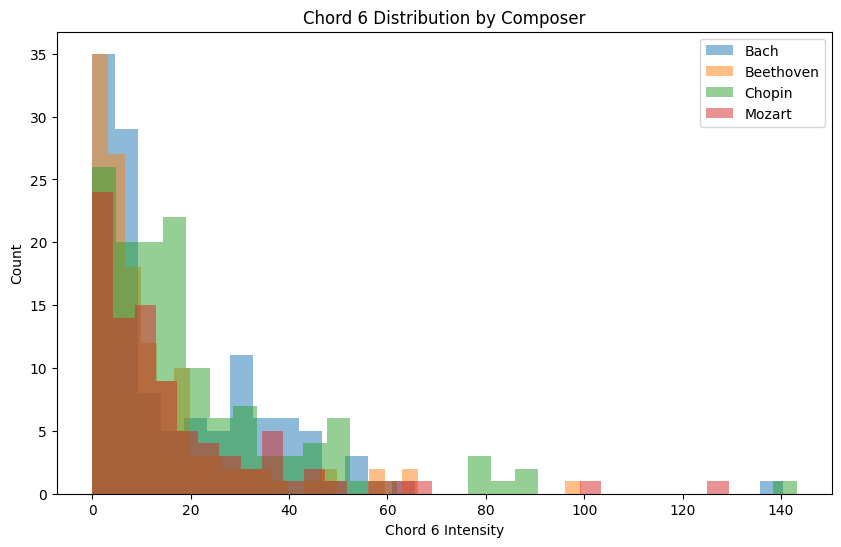

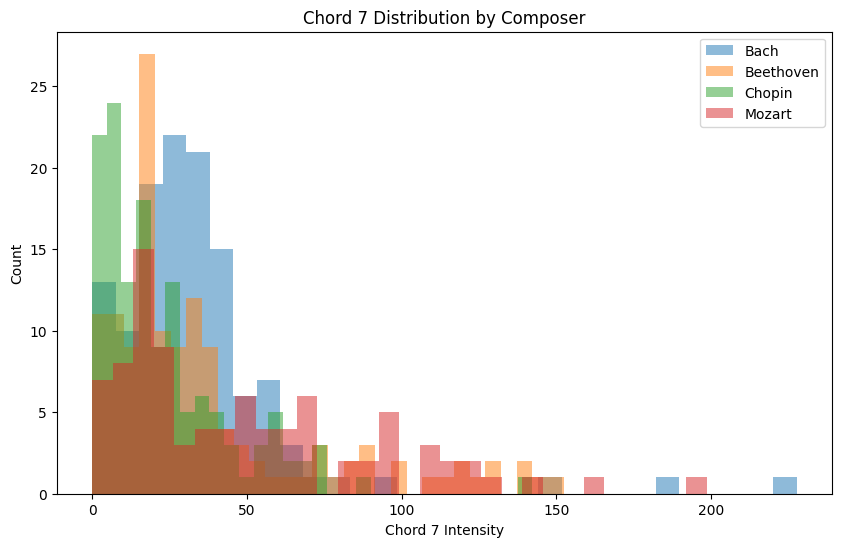

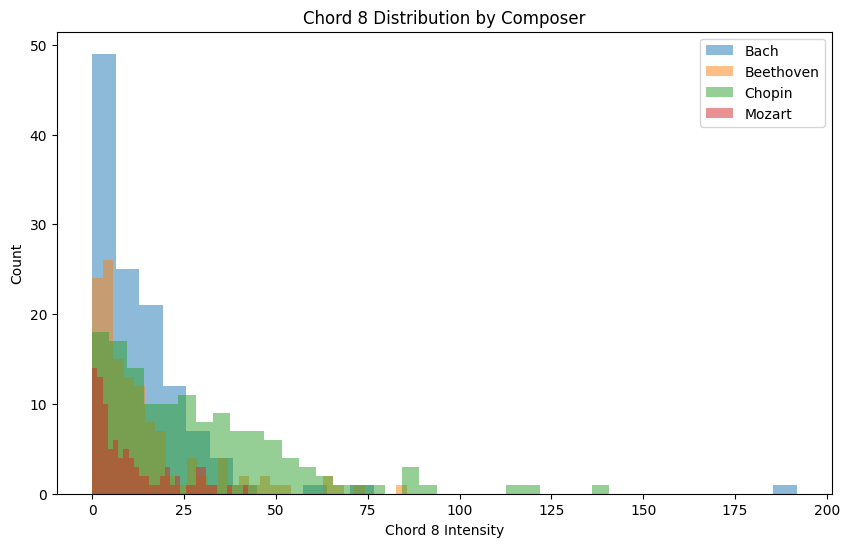

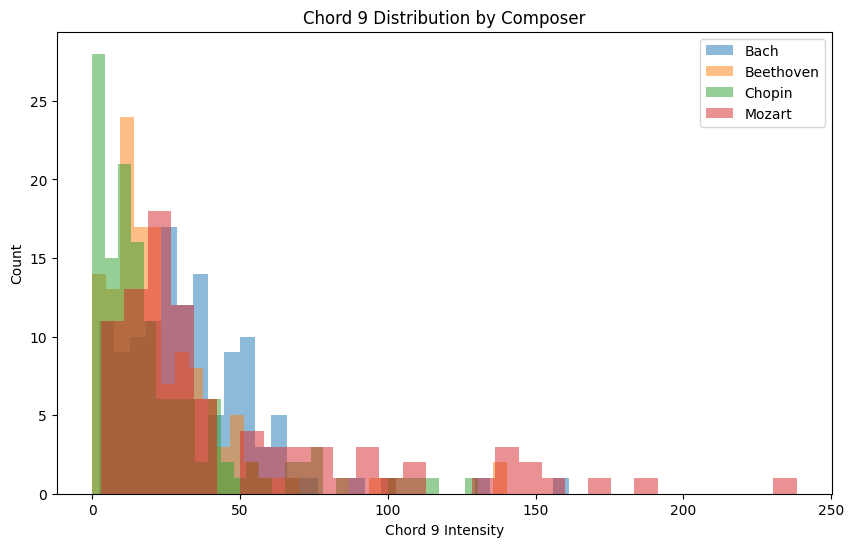

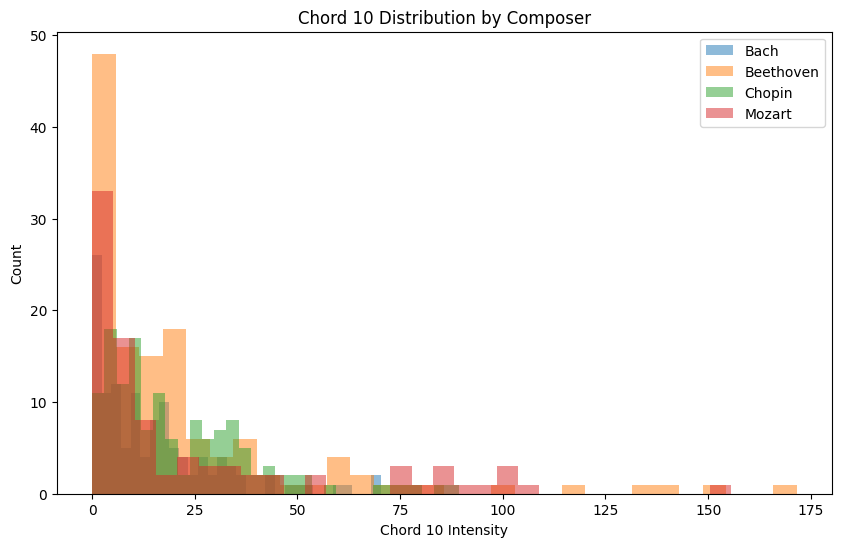

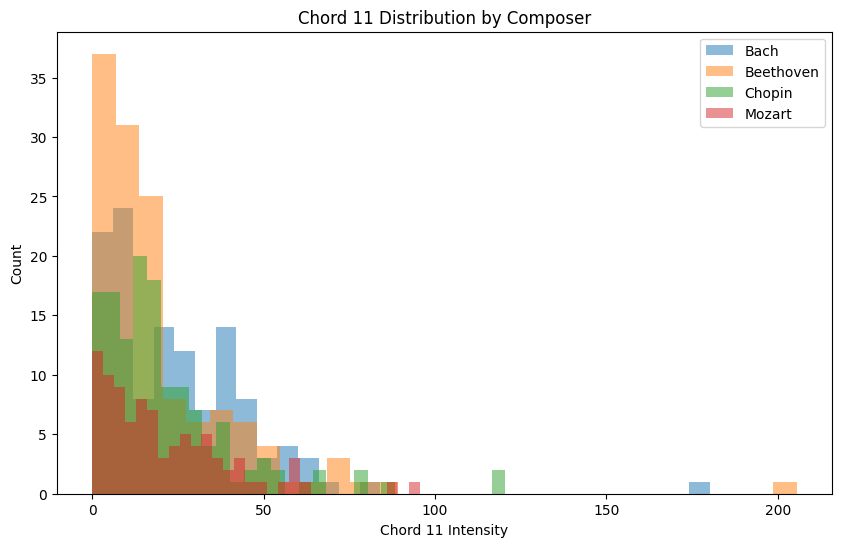

In [25]:
# Convert list of chord features to numpy array
chords = np.array(chord_f)

# Loop each pitch class from 0 to 11
for h in range(chords.shape[1]):
    plt.figure(figsize=(10, 6))

    # Plot histogram of intensity values for pitch class 'h' for each composer
    for composer in np.unique(labels):
        comp_chord = chords[labels == composer, h]
        plt.hist(comp_chord, bins=30, alpha=0.5, label=composer)
    plt.title(f"Chord {h} Distribution by Composer")
    plt.xlabel(f"Chord {h} Intensity")
    plt.ylabel("Count")
    plt.legend()
    plt.show()

# Train/Test Split + Data Prep

This section prepares the dataset for model training. I used feature scaling to normalize features.

Train test split (80-20) for class distribution in both sets.

Converted NumPy array to PyTorch tensors.

DataLoader for processing during training.

In [26]:
# Initalize standard scaler for normalization
scaler = StandardScaler()

# Features and labels before scaling
feat_all = X_full
label_all = y_full

# Normalize
feat_scaled = scaler.fit_transform(feat_all)

# Split into train and test (80/20 split)
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    feat_scaled, label_all,
    test_size=0.2,
    random_state=42,
    stratify=label_all)

# Convert to PyTorch tensors
X_train_ten = torch.tensor(X_train_np, dtype=torch.float32)
y_train_ten = torch.tensor(y_train_np, dtype=torch.long)
X_test_ten = torch.tensor(X_test_np, dtype=torch.float32)
y_test_ten = torch.tensor(y_test_np, dtype=torch.long)

# Create PyTorch tensordatasets for train/test
batch_size = 32
train_data = TensorDataset(X_train_ten, y_train_ten)
test_data = TensorDataset(X_test_ten, y_test_ten)

# Dataloaders for processing
train_load = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_load = DataLoader(test_data, batch_size=batch_size)

# CNN - LSTM Model

This model combines convolutional layers, a bidirectional LSTM, and attention to classify composers based on musical features.

Notes:
- Use dropout to reduce the overfitting.
- Add attention for interpretabilitY

In [81]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

        # Compute attention scores - linear
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, encoder_outputs):
        # Compute attention score for each time
        score = self.attention(encoder_outputs)
        # Normalize scores to weights - softmax
        attn_weights = torch.softmax(score, dim=1)
        # Sum of encoder output using the attention weights
        context_vector = torch.sum(attn_weights * encoder_outputs, dim=1)
        return context_vector, attn_weights

class ComposerCNNBiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, num_classes, dropout_prob=0.1):
        super(ComposerCNNBiLSTMWithAttention, self).__init__()
        # CNN layers
        self.cnn_layer = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_prob),

            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_prob),

            nn.Conv1d(64, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_prob)
        )
        # Bidirectional LSTM
        self.lstm = nn.LSTM(input_size=256, hidden_size=256, batch_first=True, bidirectional=True)

        # Attention method
        self.attention = Attention(hidden_dim=256*2)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(256*2, num_classes)

    # Rearrange, CNN output, dimension
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.cnn_layer(x)
        x = x.permute(0, 2, 1)

        lstm_out, _ = self.lstm(x)

        # Apply attention
        attn_out, attn_weights = self.attention(lstm_out)
        out = self.dropout(attn_out)
        out = self.fc(out)
        return out

# Class Weights

After analyzing classification reports and confusion matricies of many model attempted, I noticed some classes were imbalanced. To fix this issue, I am using class weights to give more importance to minority classes (Mozart) during training.

In [64]:
# Compute class weights
class_w = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_np),
    y=y_train_np
)

# Convert to tensor and move to GPU
class_weights = torch.tensor(class_w, dtype=torch.float32).to(gpu_device)

print("Class weights:", class_weights)

Class weights: tensor([0.9897, 0.9057, 0.8807, 1.3333], device='cuda:0')


# Initalize, Loss, Optimizer

In [82]:
# The number of features
input_feature= feat_all.shape[1]

# Number of composer classes
composer_class = len(np.unique(label_all))

model = ComposerCNNBiLSTMWithAttention(input_size=input_feature, num_classes=composer_class)
model.to(gpu_device)

# CrossEntropyLoss with class weights for imbalance
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Adam optimizer
optimize = torch.optim.Adam(model.parameters(), lr=0.001)

# Train Model

In [86]:
# Training loop
num_epochs = 120

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_feat, batch_label in train_load:
        batch_feat = batch_feat.to(gpu_device)
        batch_label = batch_label.to(gpu_device)

        optimize.zero_grad()
        outputs = model(batch_feat)
        loss = criterion(outputs, batch_label)
        loss.backward()
        optimize.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_load)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Epoch 1/120, Loss: 0.1236
Epoch 2/120, Loss: 0.0871
Epoch 3/120, Loss: 0.0651
Epoch 4/120, Loss: 0.0535
Epoch 5/120, Loss: 0.0410
Epoch 6/120, Loss: 0.0242
Epoch 7/120, Loss: 0.0203
Epoch 8/120, Loss: 0.0211
Epoch 9/120, Loss: 0.0255
Epoch 10/120, Loss: 0.0149
Epoch 11/120, Loss: 0.0113
Epoch 12/120, Loss: 0.0344
Epoch 13/120, Loss: 0.0189
Epoch 14/120, Loss: 0.0212
Epoch 15/120, Loss: 0.0416
Epoch 16/120, Loss: 0.0444
Epoch 17/120, Loss: 0.0259
Epoch 18/120, Loss: 0.0559
Epoch 19/120, Loss: 0.0286
Epoch 20/120, Loss: 0.0121
Epoch 21/120, Loss: 0.0156
Epoch 22/120, Loss: 0.0118
Epoch 23/120, Loss: 0.0120
Epoch 24/120, Loss: 0.0164
Epoch 25/120, Loss: 0.1484
Epoch 26/120, Loss: 0.1652
Epoch 27/120, Loss: 0.1116
Epoch 28/120, Loss: 0.0483
Epoch 29/120, Loss: 0.0533
Epoch 30/120, Loss: 0.0232
Epoch 31/120, Loss: 0.0282
Epoch 32/120, Loss: 0.0339
Epoch 33/120, Loss: 0.0368
Epoch 34/120, Loss: 0.0841
Epoch 35/120, Loss: 0.0475
Epoch 36/120, Loss: 0.0363
Epoch 37/120, Loss: 0.0257
Epoch 38/1

# Evaluate the Model

              precision    recall  f1-score   support

        Bach       0.71      0.88      0.79        25
   Beethoven       0.75      0.46      0.57        26
      Chopin       0.78      0.78      0.78        27
      Mozart       0.59      0.72      0.65        18

    accuracy                           0.71        96
   macro avg       0.71      0.71      0.70        96
weighted avg       0.72      0.71      0.70        96

Model Accuracy: 0.7083


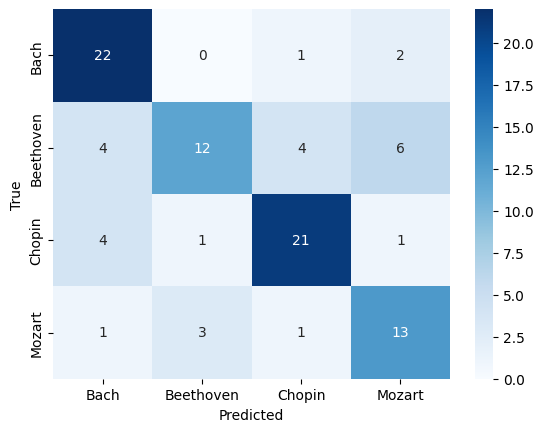

In [88]:
model.eval()
pred = []
true = []

with torch.no_grad():
    for batch_feat, batch_label in test_load:
        batch_feat = batch_feat.to(gpu_device)
        batch_label = batch_label.to(gpu_device)

        outputs = model(batch_feat)
        _, preds = torch.max(outputs, 1)

        pred.extend(preds.cpu().numpy())
        true.extend(batch_label.cpu().numpy())

# Print classification report
print(classification_report(true, pred, target_names=le.classes_))
print(f"Model Accuracy: {accuracy_score(true, pred):.4f}")

# Confusion matrix
cm = confusion_matrix(true, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()